# 変分ベイズ推論による混合ガウス分布のパラメータ推定
千葉工業大学 三上泰史  

(c)2017 Taishi Mikami 

This software is released under the MIT License, see LICENSE

## 流れ
このソースコードは、k個の2次元ガウス分布を含む混合ガウス分布から生成されたデータを使い、EMアルゴリズムを実装したものです。
1. クラスタリング対象データを生成
2. 事後分布のパラメータの初期設定 
3. K-meansを用いて平均値の初期値を定義
4. 負担率の初期化
5. 共分散、平均、クラスタに属するデータ数の三つの統計量を計算
6. Mステップの実行:α、β、ν、ｍ、Wを計算
7. Eステップの実行:負担率を更新
8. 5から7までを収束するまで繰り返す

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
#ディガンマ関数のライブラリ
from scipy.special import digamma
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
import random

### 2次元データの生成

In [2]:
def dataset(mu,cov,pi):
    for i in range(len(mu)):
        samplesB = np.random.multivariate_normal(mu[i],cov[i],int(N*pai[i])).T
        if(i>=1):
            samplesA = np.column_stack((samplesA,samplesB))
        else:
            samplesA = samplesB
    sample = np.c_[samplesA[0],samplesA[1]]
    plt.figure(figsize=(6, 6))
    plt.xlim(-2.5,2.5)
    plt.ylim(-2.5,2.5)
    plt.scatter(sample[:,0],sample[:,1],color='g',marker='+',alpha=0.8)
    return sample

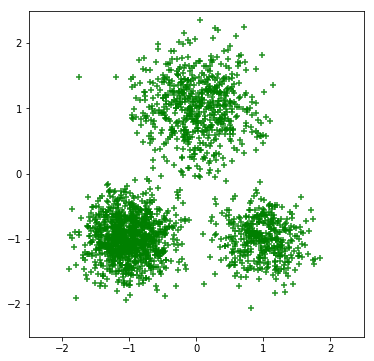

In [3]:
#データ数
N = 2000
#平均
mu = [[0,1],[-1,-1],[1,-1]]
#共分散
cov = [[[0.2,0.],[0.,0.2]],[[0.1,0.],[0.,0.1]],[[0.1,0.],[0.,0.1]],[[0.2,0.],[0.,0.2]]]
#混合率
pai=[0.3,0.5,0.2]
#事後分布の個数
K=8
#次元
D=2
samples = dataset(mu,cov,pai)
plt.scatter(samples[:,0],samples[:,1],color='g',marker='+',alpha=0.2)

### Kmeans法による平均値の推定

In [4]:
class KMeans:
    def __init__(self):
        self.k = K
        self.N = N
        self.reset()
        
    def cluster_center(self,samples):
        clus_center = []
        for i in range(self.k):
            clus_center.append([random.uniform(min(samples[:,0]),max(samples[:,0])),random.uniform(min(samples[:,1]),max(samples[:,1]))])
        self.mu = np.array(clus_center)
        
    def reset(self):
        self.label = []
        self.count = np.zeros((self.k,1))
        self.sum = np.zeros((self.k,2))
        self.t = np.zeros((self.k,1))
        
    def draw(self,sample,mu,label):
        
        #新しい描画を開始
        plt.figure(figsize=(6, 6))
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        plt.scatter(sample[:,0],sample[:,1],s=20,c=label,marker='+',edgecolors='k',alpha=0.4)
        plt.scatter(mu[:,0],mu[:,1],s=100,marker="x",edgecolors='k')
        
    def EM_step(self,sample,mu):
        #変数の初期化
        self.reset()
        
        #2点間の二乗距離
        for n in range(self.N):
            distance = []
            distance = [np.linalg.norm(self.mu[i] - sample[n]) for i in range(self.k)]
            
            #クラス分け
            self.label.append(distance.index(min(distance)))
            self.count[distance.index(min(distance))] += 1
            self.sum[distance.index(min(distance))] += sample[n]
        
        #クラスタ中心の更新
        for i in range(0,self.k):
            self.mu[i] = self.sum[i]/self.count[i]

推定結果
[[-0.01085838  0.53368763]
 [ 1.2053617  -1.17640839]
 [-0.38738363  1.28430888]
 [ 0.79056598 -0.84621459]
 [-0.7363428  -0.77797267]
 [-0.97198497 -1.31043025]
 [-1.30086469 -0.84230837]
 [ 0.41563953  1.20168276]]


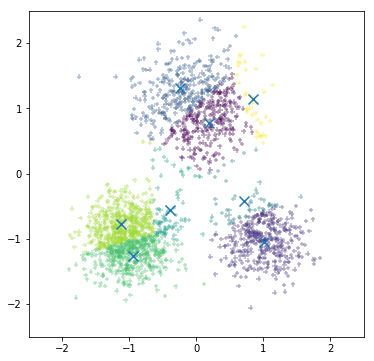

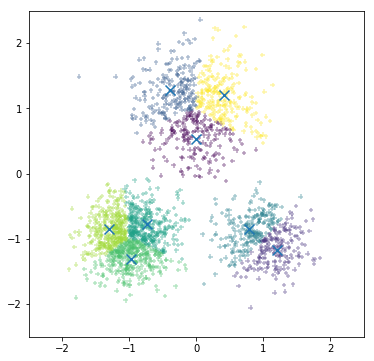

In [5]:
model = KMeans()
model.cluster_center(samples)
model.EM_step(samples,model.mu)
model.draw(samples,model.mu,model.label)
for i in range(10):
    model.EM_step(samples,model.mu)
model.draw(samples,model.mu,model.label)
clus_center = model.mu
print("推定結果")
print(clus_center)

In [6]:
def make_gauss_model(mu,sigma):
    gauss = []
    for i in range(K):
        gauss.append(multivariate_normal(mean=mu[i],cov=sigma[i]))
    return gauss

In [7]:
def draw(gauss):
    plt.figure(figsize=(6, 6))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    
    for i in range(K):
        z = gauss[i].pdf(pos)
        if pai[i] > 0.01: 
            plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    for i in range(N):
        #plt.xlim(min(samples[:,0])+0.1,max(samples[:,0])+0.1)
        #plt.ylim(min(samples[:,1])+0.1,max(samples[:,1])+0.1)
        plt.scatter(samples[i][0],samples[i][1],color="g",marker='+',alpha=0.3)

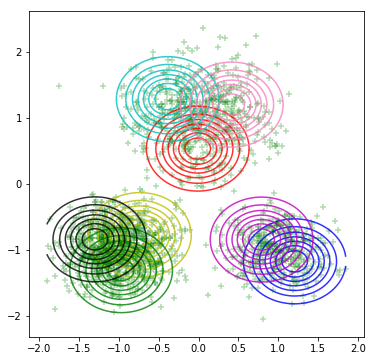

In [8]:
g_sigma = [[[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]]]
pai = [1.0/K for i in range(K)]
clus = ["r","b","c","m","y","g","k", '#f781bf']
gauss = make_gauss_model(clus_center,g_sigma)
draw(gauss)

### 負担率の初期化

In [9]:
def ganma_init():
    ganma = []
    for i in range(N):
        sum_p = 0.0
        p=[]
        for j in range(K):
            sum_p += pai[j]*gauss[j].pdf([samples[i][0],samples[i][1]])
        for j in range(K):
            p.append(pai[j]*gauss[j].pdf([samples[i][0],samples[i][1]])/sum_p)
        ganma.append(p)
    return ganma

### 3つの統計量の計算

In [10]:
def cal(ganma):
    #行列の初期化
    mu = np.zeros((K,D))
    S = np.zeros((K,D,D))
    N_k = []
    
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
             sum_r += ganma[n][k]
        N_k.append(sum_r)
        
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
            sum_r += ganma[n][k]*samples[n]
        mu[k] = sum_r/N_k[k]
        sigma = []
        sigma = [samples[j]-mu[k] for j in range(N)]
        tmp = np.zeros((1,D,D))
        for n in range(N):
            tmp += (ganma[n][k]*sigma[n])*sigma[n][:, np.newaxis]
        tmp2 = tmp/N_k[k]
        S[k] = tmp2
    return N_k,mu,S

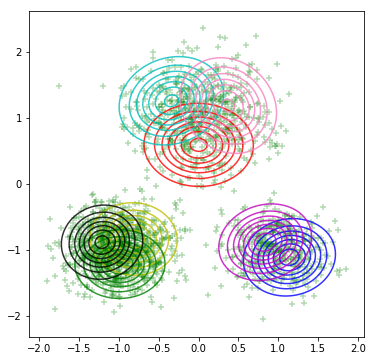

In [11]:
ganma = ganma_init()
N_k,mu,S = cal(ganma)
gauss = make_gauss_model(mu,S)
draw(gauss)

### M-step

In [12]:
def M_step(N_k,mu,S):
    alpha_0 = 0.01
    beta_0 = 0.01
    nu_0 = 1.0
    m_0 = np.zeros((K,D))
    m = np.zeros((K,D))
    W_0 = np.identity(2)
    alpha=[]
    beta=[]
    nu=[]
    W = np.zeros((K,D,D))
    for k in range(K):
        alpha.append(alpha_0 + N_k[k])
        beta.append(beta_0 + N_k[k])
        nu.append(nu_0 + N_k[k])
        m[k] = (beta_0*m_0[k] + N_k[k]*mu[k])/beta[k]
    sigma = []
    sigma = [mu[j]-m_0[j] for j in range(K)]
    for k in range(K):
        tmp = beta_0*N_k[k]*sigma[k]*sigma[k][:, np.newaxis]/(beta_0 + N_k[k])
        tmp2 = la.inv(W_0)+N_k[k]*S[k]+tmp
        W[k] = la.inv(tmp2)
    return alpha,beta,nu,m,W,alpha_0,beta_0,nu_0,m_0,W_0

### E-step

In [13]:
def E_step(alpha,beta,nu,m,W):
    E_ln_A = []
    E_ln_pi = []
    E_mu_A = []
    r = []
    for k in range(K):
        tmp = sum([digamma((nu[k]+1-i)/2)for i in range(1,D+1)])
        E = tmp +D*math.log(2)+math.log(la.norm(W[k]))
        E_ln_A.append(E)
        
        E = digamma(alpha[k])-digamma(sum(alpha))
        E_ln_pi.append(E)
    for n in range(N):
        tmp = [(D/beta[k])+nu[k]*np.dot((samples[n] - m[k]),np.dot(W[k],(samples[n] - m[k]).T)) for k in range(K)]
        E_mu_A.append(tmp)
    for n in range(N):
        tmp = [np.exp(np.array(E_ln_pi[k]) + np.array(E_ln_A[k])/2 - D*math.log(2*math.pi)/2-np.array(E_mu_A[n][k])/2) for k in range(K)]
        for k in range(K):
            if tmp[k] < 1e-10:
                tmp[k] = 1e-10
        tmp2 = np.array(tmp)/sum(tmp)
        
        r.append(tmp2)
    return E_ln_A,E_ln_pi,E_mu_A,r

In [14]:
#lower bound
#a=0.0
#for k in range(K):
#    a += (N_k[k]*(E_ln_A[k]-D/beta[k]-nu[k]*np.trace(S[k].dot(W[k]))-nu[k]*(mu[k]-m[k]).dot(W[k].dot((mu[k]-m[k])[:, np.newaxis]))-D*math.log(2*math.pi)))
#E1 = a/2.0
#b=[]
#for n in range(N):
#    b.append(sum([ganma[n][k]*E_ln_pi[k] for k in range(K)]))
#E2 = sum(b)

#c = 1.0
#for k in range(K):
#    c = c*math.gamma(alpha_0)
#c2 = math.gamma(alpha_0*K)/c

#E3 = math.log(c2) + (alpha_0 - 1)*sum(E_ln_pi)

#a = 0.0
#for k in range(K):
#    a += D*math.log(beta_0/2*math.pi) + E_ln_A[k] - D*beta_0/beta[k] -beta_0*nu[k]*(m[k]-m_0[k]).dot(W[k].dot((m[k]-m_0[k])[:, np.newaxis]))
#a = a/2.0

#c = 1.0
#for i in range(D):
#    c = c*math.gamma((nu_0+2-i)/2)

#B = 1/(pow(2,nu_0*D/2)*pow(math.pi,D*(D-1)/4)*c)*pow(la.norm(W_0),nu_0/2)
#B = K*math.log(B)

#E4 = a + B + (nu_0-D-1)*sum(E_ln_A)/2 - sum([nu[k]*np.trace((la.inv(W_0)).dot(W[k])) for k in range(K)])/2

#b=[]
#for n in range(N):
#    b.append(sum([ganma[n][k]*math.log(ganma[n][k]) for k in range(K)]))
#E5 = sum(b)

#c = 1.0
#for k in range(K):
#    c = c*math.gamma(150)
#c2 = math.gamma(sum(alpha))/c
#print(c2)
#a=0.0
#for k in range(K):
#    a += (alpha[k]-1)*E_ln_pi[k]
#E6 = a 

### 収束判定

In [15]:
def convergence(pai2,n):
    z = np.array(pai2[n-1])-np.array(pai2[n])
    for i in range(K):
        if math.fabs(z[i])<0.001:
            fin[i] = 1 
    return sum(fin)

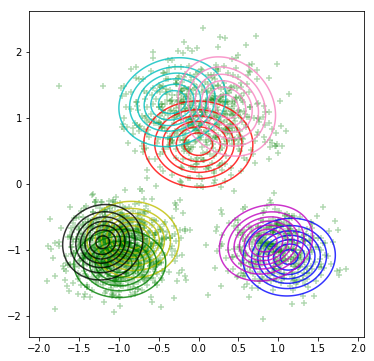

count:0
[ 0.09324056  0.09491142  0.09967117  0.10470519  0.16270085  0.16944157
  0.16853483  0.10504473]


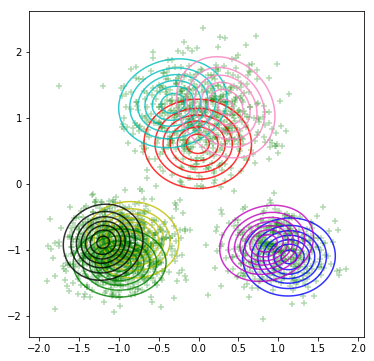

count:1
[ 0.09035786  0.09308233  0.10007339  0.10621135  0.16226927  0.17065722
  0.16736317  0.10823574]


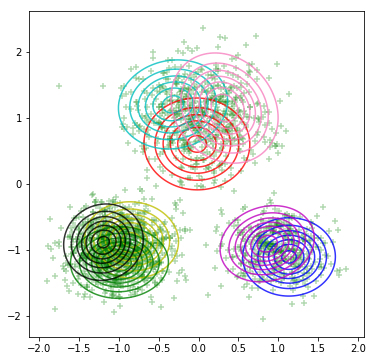

count:2
[ 0.08640715  0.0908859   0.09993384  0.10822876  0.16277218  0.17271085
  0.16467054  0.11264112]


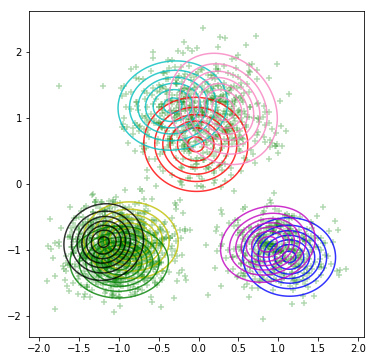

count:3
[ 0.08120236  0.0880563   0.09910691  0.11094215  0.16381986  0.17591318
  0.16031557  0.11889403]


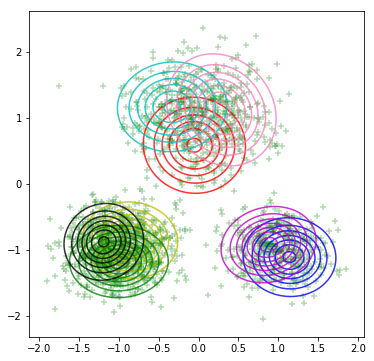

count:4
[ 0.07440674  0.08425299  0.09734026  0.11466169  0.16543978  0.18069939
  0.15383057  0.12761894]


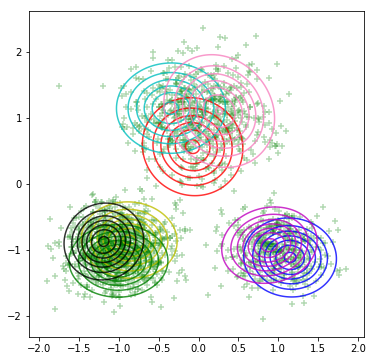

count:5
[ 0.06568244  0.07908356  0.09421928  0.11976659  0.16775348  0.18765127
  0.14451558  0.13957819]


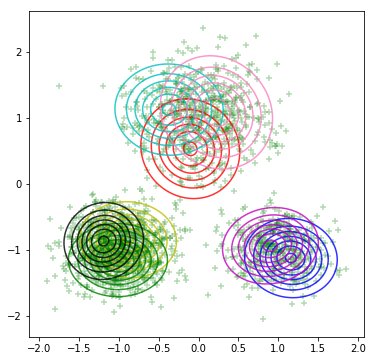

count:6
[ 0.05476994  0.07208394  0.08907544  0.12671419  0.17090279  0.19752402
  0.13147739  0.15570271]


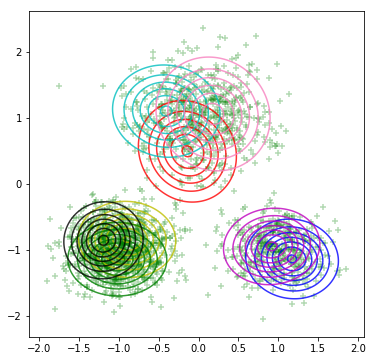

count:7
[ 0.04168302  0.06276459  0.08090472  0.13598919  0.17492885  0.21121893
  0.11377778  0.17698342]


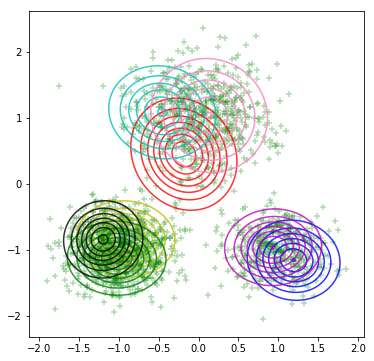

count:8
[ 0.02714951  0.05079479  0.06843845  0.14791581  0.17948886  0.22959989
  0.09089141  0.20397197]


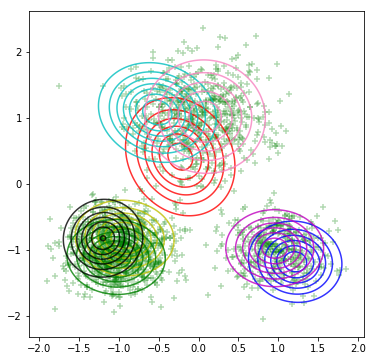

count:9
[ 0.01336189  0.03645089  0.05082386  0.16220817  0.18326987  0.25299892
  0.06375022  0.23538745]


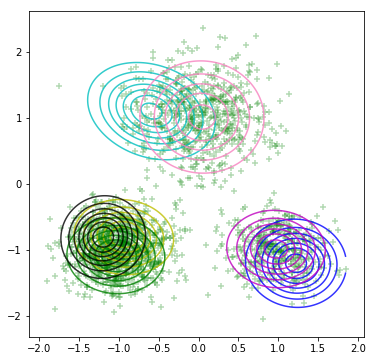

count:10
[ 0.00393166  0.02136481  0.02970477  0.17723562  0.18321691  0.28047371
  0.03620395  0.26612214]


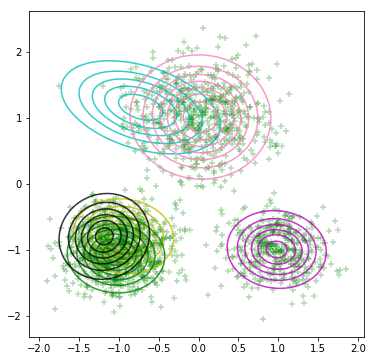

count:11
[ 0.00035022  0.00888986  0.0114569   0.18968633  0.17486996  0.30989263
  0.01476091  0.28837165]


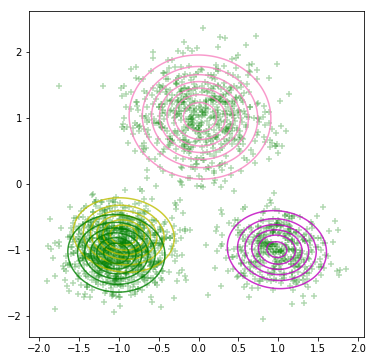

count:12
[  6.98388510e-24   2.05335896e-03   2.37054318e-03   1.96561701e-01
   1.55195989e-01   3.40322546e-01   3.61138630e-03   2.98385562e-01]


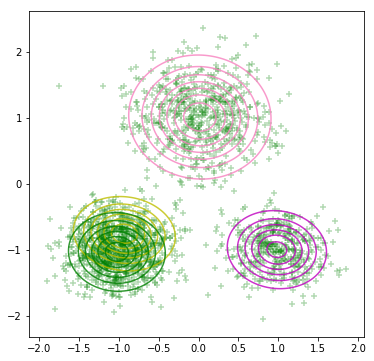

count:13
[  1.06638239e-47   5.71738400e-05   1.60708541e-04   1.98663661e-01
   1.24784996e-01   3.73888056e-01   2.56131538e-04   3.00838845e-01]


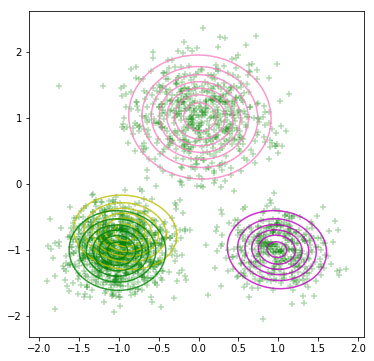

count:14
[  1.06669691e-47   3.33339300e-47   2.66397869e-36   1.98890972e-01
   8.68187400e-02   4.12240305e-01   2.68058939e-32   3.01275459e-01]


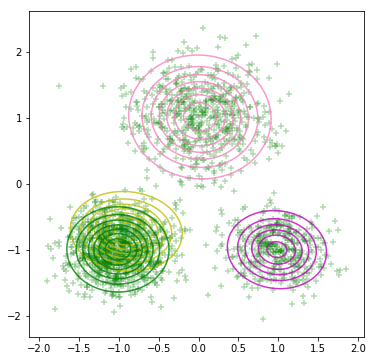

count:15
[  1.06642585e-47   1.06642585e-47   1.06642585e-47   1.98867619e-01
   4.77165618e-02   4.51389916e-01   1.06642585e-47   3.01256059e-01]


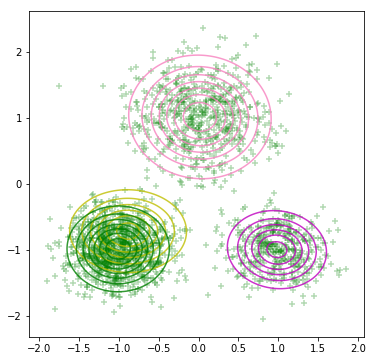

count:16
[  1.06632786e-47   1.06632786e-47   1.06632786e-47   1.98835606e-01
   1.78901784e-02   4.81415280e-01   1.06632786e-47   3.01089454e-01]


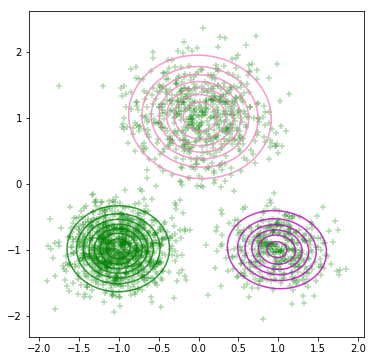

count:17
[  1.06624249e-47   1.06624249e-47   1.06624249e-47   1.98802716e-01
   3.72266450e-03   4.95886591e-01   1.06624249e-47   3.00820757e-01]


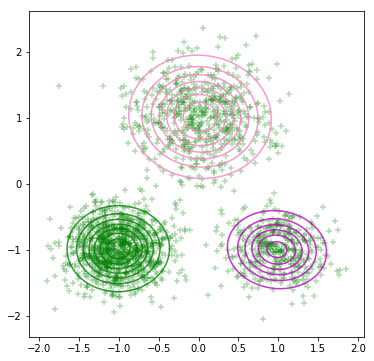

count:18
[  1.06619572e-47   1.06619572e-47   1.06619572e-47   1.98785701e-01
   1.79834605e-04   4.99699918e-01   1.06619572e-47   3.00606551e-01]


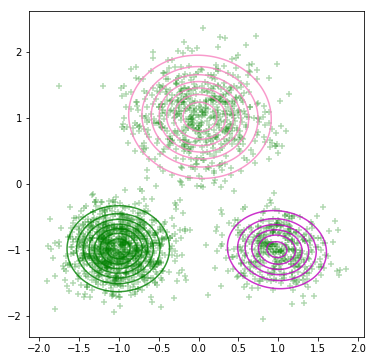

count:19
[  1.06618321e-47   1.06618321e-47   1.06618321e-47   1.98793266e-01
   1.78999062e-40   5.00176142e-01   1.06618321e-47   3.00504581e-01]
finish!!!!:iter=20


In [16]:
count = 100
pai2 = []
fin = [0 for i in range(K)]
for i in range(count):
    alpha,beta,nu,m,W,alpha_0,beta_0,nu_0,m_0,W_0 = M_step(N_k,mu,S)
    E_ln_A,E_ln_pi,E_mu_A,ganma = E_step(alpha,beta,nu,m,W)
    pai2.append(pai)
    if i > 1:
        juge = convergence(pai2,i)
        if juge == K:
            print("finish!!!!")
            fin_count = i
            break
    pai = np.exp(E_ln_pi)
    N_k,mu,S = cal(ganma)
    gauss = make_gauss_model(mu,S)
    draw(gauss)
    plt.show()
    print("count:{}".format(i))
    print(pai)

### 混合率の推移

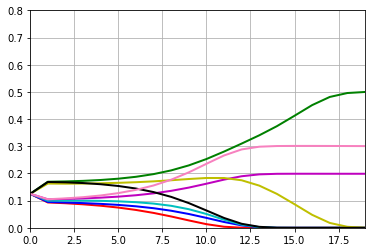

In [17]:
x = [i for i in range(fin_count)]
y = []
for k in range(K):
    y =  [pai2[j][k] for j in range(fin_count)]
    plt.plot(x,y,linewidth=2, color=clus[k])
    plt.xlim(0,fin_count-1)
    plt.ylim(0,0.8)
    plt.grid(True)
